In [1]:
# Importing standard packages for data exploration and processing.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# Our data has no header row.
data = pd.read_csv('data/kaggle/1_steam-200k.csv', header=None)
data.head()

,0,1,2,3,4
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       200000 non-null  int64  
 1   1       200000 non-null  object 
 2   2       200000 non-null  object 
 3   3       200000 non-null  float64
 4   4       200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [3]:
data.describe()

,0,3,4
count,2.000000e+05,200000.000000,200000.0
mean,1.036559e+08,17.874384,0.0
std,7.208074e+07,138.056952,0.0
min,5.250000e+03,0.100000,0.0
25%,4.738420e+07,1.000000,0.0
50%,8.691201e+07,1.000000,0.0
75%,1.542309e+08,1.300000,0.0
max,3.099031e+08,11754.000000,0.0


In [4]:
# The last column is useless.
data.drop(4, axis=1, inplace=True)

# Current column names are not very informative, are they?
header = ['Player_id', 'Game', 'Action', 'Amount']
data.columns = header
data.head()

,Player_id,Game,Action,Amount
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [5]:
# Not all people that buy a game ever play it.
data['Action'].value_counts()

purchase    129511
play         70489
Name: Action, dtype: int64

In [6]:
# Is a purchase always for one game, and how many hours were played in total?
data.groupby('Action')['Amount'].sum()

Action
play        3445365.8
purchase     129511.0
Name: Amount, dtype: float64

In [7]:
# We need to aggregate the data to a game level and get both the number of people who bought and played it.
summary = data.pivot_table(index='Game', columns='Action', values='Amount', aggfunc='count')

# And also the total amount of hours played - not actual for purchases since count = sum for them as seen above.
summary['time'] = data[data['Action'] == 'play'].groupby('Game').sum()['Amount']

summary.reset_index(inplace=True)
summary.rename_axis(None, axis=1, inplace=True)
summary.head()

,Game,play,purchase,time
0,007 Legends,1.0,1.0,0.7
1,0RBITALIS,3.0,3.0,1.2
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,5.0,7.0,20.0
3,10 Second Ninja,2.0,6.0,5.9
4,"10,000,000",1.0,1.0,3.6


In [8]:
# It would make more sense to have the 'play' columns next to each other.
summary.columns = ['Game', 'Played', 'Purchased', 'Play time']
summary = summary[['Game', 'Purchased', 'Played', 'Play time']]
summary.head()

,Game,Purchased,Played,Play time
0,007 Legends,1.0,1.0,0.7
1,0RBITALIS,3.0,3.0,1.2
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7.0,5.0,20.0
3,10 Second Ninja,6.0,2.0,5.9
4,"10,000,000",1.0,1.0,3.6


In [9]:
summary.describe()

,Purchased,Played,Play time
count,5155.000000,3600.000000,3600.000000
mean,25.123375,19.580278,957.046056
std,101.572586,104.314868,17930.737469
min,1.000000,1.000000,0.100000
25%,2.000000,1.000000,3.100000
50%,5.000000,4.000000,15.100000
75%,18.000000,12.000000,97.575000
max,4841.000000,4841.000000,981684.600000


Quite a lot of games that were bought but never played in our data, is it not? 5155 games have at least one purchase while only 3600 games have at least one person that played them. Since we are not really interested in such unpopular games, let us put some minimum qualifying restrictions. We are not going to put any restrictions on the purchases as we will not divide anything by it.

In [10]:
summary = summary[(summary['Purchased'] >= 10) & (summary['Play time'] >= 100)]
summary.reset_index(drop=True, inplace=True)

# We are also interested in how likely someone is to play a game after purchasing it and for how many hours.
# Let us call those metrics 'Conversion' and 'Dedication' accordingly.
summary['Conversion'] = summary['Played'] / summary['Purchased']
summary['Dedication'] = summary['Play time'] / summary['Purchased']

# Clean it up visually a bit.
summary = summary.round(2)
summary[['Purchased', 'Played']] = summary[['Purchased', 'Played']].astype('int64')
summary.head()

,Game,Purchased,Played,Play time,Conversion,Dedication
0,3DMark,18,18,240.8,1.00,13.38
1,7 Days to Die,103,98,4075.5,0.95,39.57
2,A.V.A - Alliance of Valiant Arms,63,27,109.1,0.43,1.73
3,APB Reloaded,262,138,9237.2,0.53,35.26
4,ARK Survival Evolved,163,158,13593.1,0.97,83.39


In [11]:
len(summary)

783

783 games, not bad. We need to remember that the data used here is nowhere near the actual popularity of the games as it only contains 200,000 actions and is rather old. Moreover, some games might not be properly represented due to the small scale of dataset. However, we can presume that at least for the most popular games that should not be the case. And let us create a shortlist of games with stricter qualifying requirements.

In [12]:
shortlist = summary[(summary['Purchased'] >= 100) & (summary['Play time'] >= 1000)]
shortlist.reset_index(drop=True, inplace=True)
shortlist.head()

,Game,Purchased,Played,Play time,Conversion,Dedication
0,7 Days to Die,103,98,4075.5,0.95,39.57
1,APB Reloaded,262,138,9237.2,0.53,35.26
2,ARK Survival Evolved,163,158,13593.1,0.97,83.39
3,AdVenture Capitalist,222,141,6067.7,0.64,27.33
4,Age of Empires II HD Edition,238,200,6858.5,0.84,28.82


In [13]:
len(shortlist)

155

155 games, now that should be much easier to look at and analyse one by one when we need it. But let us first start by analysing the general statistics for both dataframes.

In [14]:
summary.describe()

,Purchased,Played,Play time,Conversion,Dedication
count,783.000000,783.000000,783.000000,783.000000,783.000000
mean,111.197957,74.393359,4303.685185,0.678595,21.597484
std,237.255413,214.773886,38279.790989,0.219079,40.289269
min,10.000000,1.000000,100.300000,0.060000,0.190000
25%,29.000000,18.000000,200.100000,0.510000,4.945000
50%,57.000000,35.000000,468.500000,0.710000,10.160000
75%,113.500000,71.000000,1418.200000,0.860000,20.540000
max,4841.000000,4841.000000,981684.600000,1.000000,385.570000


Very interesting. Almost 75% of games have less than an average amount of purchases, which means that the mean is largely driven by a smaller number of very popular games. That effect stays the same for the dedication values (which, again, are measured as average time spent  and is even more pronounced for the total number of hours recorded, for which the mean is three times the 75% quantile value.

And just look at the max values for all columns. One game was purchased almost 5,000 times while we had only 130,000 purchases in our original dataset, meaning that around 3.8% of all purchases were for that one particular game - 44 times the average of our summary dataset.

Interestingly, the max value for number of people who has ever played a game is exactly the same as for the number of people who bought it. Most likely, it is the same game. And since we had only 70,000 game launches in our original dataset, this game in question also accounts for around 6.9% of all game lanches - 65 times the average of our summary dataset.

Similarly, some game has 228 times the mean play time of summary dataset. Even when compared to the original dataset before eliminating less popular games, it accounts for 28.5% of all play time! That one game alone has more play time than the least played 75% of the games combined.

At the same time, on average only 2/3 out of all game purchases result in the person actually launching the game at least once. Interestingly enough, that is lower than the 50% quantile value meaning and the distance between the 25% and 50% quantiles is higher than 50% and 75% quantiles. That makes sense since some a number of games probably have extremely low conversion rates and that is driving the mean down.

Now dedication is a much more tricky subject. Not all games possess the same level of replayability to begin with, as many games are storyline-driven and intended for a certain amount of play time. It is often multiplayer or sandbox games that can rack up a huge amount of hours played. As such, it is not really fair to compare the dedication values of different games without taking into consideration the nature of these games. For example, we could compare the dedication of players to different strategy games.

In [15]:
shortlist.describe()

,Purchased,Played,Play time,Conversion,Dedication
count,155.000000,155.000000,155.000000,155.000000,155.000000
mean,319.477419,235.787097,18460.578710,0.715290,34.450194
std,461.029598,445.950495,84669.048622,0.195639,44.773612
min,100.000000,26.000000,1002.800000,0.160000,2.530000
25%,142.000000,102.000000,1816.950000,0.560000,10.165000
50%,207.000000,146.000000,3581.900000,0.760000,17.860000
75%,313.000000,203.000000,8840.300000,0.870000,38.690000
max,4841.000000,4841.000000,981684.600000,1.000000,310.660000


Despite further restricting our dataset we are observing the exact same behaviour as before. The means for all three main indicators (purchases, launches and total play time) are around the 75% quantile value while the mean for play time much exceeds it, although not as severely as before. It appears that such behaviour might be standard for any random dataset of games that we get, at the time this data was collected at least.

What is interesting is that while the most of max values stayed the same, the maximum value for dedication has dropped from 385 to 310. Apparently, some game was extremely popular among the people who bought it but did not have enough purchases to make it into the shortlist. Would be very interesting to take a look at that game.

In [16]:
# Top purchased.
summary.nlargest(5, 'Purchased')

,Game,Purchased,Played,Play time,Conversion,Dedication
208,Dota 2,4841,4841,981684.6,1.00,202.79
648,Team Fortress 2,2323,2323,173673.3,1.00,74.76
736,Unturned,1563,1069,16096.4,0.68,10.30
143,Counter-Strike Global Offensive,1412,1377,322771.6,0.98,228.59
335,Half-Life 2 Lost Coast,981,177,184.4,0.18,0.19


In [17]:
# Top played.
summary.nlargest(5, 'Played')

,Game,Purchased,Played,Play time,Conversion,Dedication
208,Dota 2,4841,4841,981684.6,1.00,202.79
648,Team Fortress 2,2323,2323,173673.3,1.00,74.76
143,Counter-Strike Global Offensive,1412,1377,322771.6,0.98,228.59
736,Unturned,1563,1069,16096.4,0.68,10.30
384,Left 4 Dead 2,951,801,33596.7,0.84,35.33


In [18]:
# Top play time.
summary.nlargest(5, 'Play time')

,Game,Purchased,Played,Play time,Conversion,Dedication
208,Dota 2,4841,4841,981684.6,1.00,202.79
143,Counter-Strike Global Offensive,1412,1377,322771.6,0.98,228.59
648,Team Fortress 2,2323,2323,173673.3,1.00,74.76
140,Counter-Strike,856,568,134261.1,0.66,156.85
581,Sid Meier's Civilization V,596,554,99821.3,0.93,167.49


In [19]:
# Top played as a percentage of purchased.
summary.nlargest(5, 'Conversion')

,Game,Purchased,Played,Play time,Conversion,Dedication
0,3DMark,18,18,240.8,1.0,13.38
9,Age of Chivalry,58,58,970.0,1.0,16.72
20,Alien Swarm,289,289,1505.0,1.0,5.21
111,Call of Juarez The Cartel,16,16,104.8,1.0,6.55
112,Car Mechanic Simulator 2015,13,13,110.6,1.0,8.51


In [20]:
# Top played by average buyer.
summary.nlargest(5, 'Dedication')

,Game,Purchased,Played,Play time,Conversion,Dedication
279,Football Manager 2012,80,79,30845.8,0.99,385.57
281,Football Manager 2014,80,78,30574.8,0.98,382.18
277,Football Manager 2010,38,35,13126.7,0.92,345.44
278,Football Manager 2011,34,31,11336.8,0.91,333.44
280,Football Manager 2013,104,104,32308.6,1.00,310.66


Without much surprise, the first spot for three core indicators were taken by Dota 2 which is a very much a cult game. We also have game such as 'Counter-Strike', 'Counter-Strike Global Offensive' and 'Sid Meier's Civilization V' in the tops which all look perfectly normal. 'Team Fortress 2' is also in the top of games by total play time despite having a considerably smaller conversion rates than the rest of the top.

Three games deserve a closer look, all of which are featured in the top purchased games. 'Unturned' has a spot in both purchased and played games despite having a rather small play time and 'Left 4 Dead 2' acts in a similar manner. At the same time, the iconic 'Half-Life 2 Lost Coast' has many purchases, relatively low conversion rate and almost no play time.

The first kind of situation is probably caused by the lack of replayability where the game is mainly storyline-driven. It is a good game, just not the one meant to be played for hundred of hours. As for 'Half-Life 2 Lost Coast', it is taken to the extreme as the game is actually a very short part of a level from the main game 'Half-Life 2'.

The top for the conversion rate is a curious one. It includes only the games for which every single person who bought them also played them, however long. Three of them appear rather niche but 'Age of Chivalry' and 'Alien Swarm' are fairly popular. And we can see in general that most of the games in the top of both number of purchases and play time have percentages either close to 100% or around 65-70%. 

But the most interesting thing is the top for dedication. All of it is taken by different editions of 'Football Manager' franchise. What makes it so special? Is it an extreme replayability or extreme loyalty of the franchise's fanbase? Probably a bit of both, especially since we can see that almost all people who bought the game played it - so the fanbase must be pretty loyal. But also a third and very important factor.

In 'Football Manager', you do not need to actively interact with the game all the time. Since you act as a team's manager, a lot of the time the game would be running in the background simulating all matches of a season until a player's intervention is necessary. That is the case for most sports management games, and a good example of why average play time per buyer (and play time in general) can be ill-representative of the actual popularity of the game.

Let us plot the behaviour of all indicators to show graphically the differences and similarities. Since the min and max values are very different, we are going to use logarithms. In effect, the growth of a feature's logarithm would be close enough to the rate at which that particular feature grows.

In [21]:
def plot_ascending(df):
    name = df.name
    values = df.sort_values()
    values.reset_index(drop=True, inplace=True)
    
    # Scaling the values to compare graphs with each other.
    values = (values - values.min()) / (values.max() - values.min())
    values = np.log(values + 1)
    plt.plot(values, label=name)

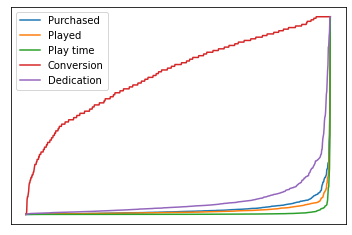

In [22]:
for column in summary.columns[1:]:
    plot_ascending(summary[column])

plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

Overall, four out of five lines seem to show a fairly similar behaviour. The growth rates for all of them are extremely skewed towards a smaller number of more popular games located on the right of the graph. That effect is the weakest for dedication, much stronger for the number of purchases, somewhat stronger for the number of players and extremely strong for the total play time.

The conversion rate is a rather different metric so it should be no surprise. We can see that there is a group of games that are clearly less popular among their buyers but then the percentage quickly jumps and grows steadily for most of the graph. Basically, as long as you are not among those unlucky hundred games or so you are fine.

Let us better illustrate it with a plot of cumulative values. The conversion rate and the dedication are not going to be included in the next graph as it makes little sense for us to calculate the cumulative values of it. After all, they were calculated by dividing one of the three core indicators by another one and are proportions, not absolute values.

In [23]:
def plot_cumulative(df):
    name = df.name
    values = df.sort_values()
    values.reset_index(drop=True, inplace=True)
    
    # We need to both calculate the cumulative values and rescale them as proportion of total.
    values = values.cumsum()
    values = values / values.max()
    plt.plot(values, label=name)

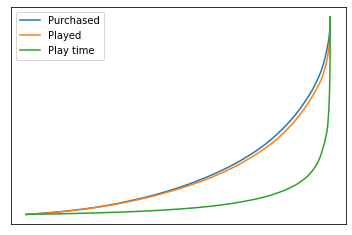

In [24]:
for column in summary.columns[1:4]:
    plot_cumulative(summary[column])

plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

Indeed, the lines look much smoother now than when we were looking at the growth rates, although the cumulative values of hours played are still heavily skewed compared to the number of purchases. Should not be too much of a surprise though, since we have already discovered before that the most played game alone accounts for 28,5% of all play time. Now let us look at the game series created by Paradox Development Studio.

In [25]:
# Many Paradox Interactive games are in fact DLCs, which usually do not have play time and thus are not in this list.
paradox_list = ['Europa Universalis',  'Victoria', 'Hearts of Iron', 'Crusader Kings', 'Stellaris', 'Imperator: Rome']
paradox_games = summary[summary['Game'].str.contains('|'.join(paradox_list))]
paradox_games

,Game,Purchased,Played,Play time,Conversion,Dedication
148,Crusader Kings II,102,76,9020.7,0.75,88.44
238,Europa Universalis III,37,16,1083.0,0.43,29.27
239,Europa Universalis IV,52,50,9759.0,0.96,187.67
342,Hearts of Iron III,24,21,1203.0,0.88,50.12
742,Victoria II,19,14,575.1,0.74,30.27


Unsurprisingly, we do not have 'Stellaris' and 'Imperator: Rome' games in the list as those two games were published after this dataset was gathered. All games present in the list are around 5-10 years old at the moment when data was gathered. Their behaviour is rather interesting though. 

The conversion rates for Paradox Interactive games is above the mean value, potentially thanks to both them being sandbox games and the studio's rather loyal community. Andespite being the youngest two in the list, both 'Crusader Kings II' and 'Europa Universalis IV' have a considerably higher number of purchases and much higher play time and dedication. The latter are especially large for 'Europa Universalis IV', which might be in part attributed to its large and active multiplayer community. 

The conversion rates are generally pretty good and are at around 50% quantile ('Crusader Kings II', 'Victoria II') or 75% quantile ('Hearts of Iron III'). The only outliers are the games from the 'Europa Universalis' series, where the third game has a very low conversion rate while the fourth game has a very high one. It also helps explain some of the difference in dedication values as most of 'Europa Universalis III' players never even launched it.

It seems overall that the either the new games in the series were very much improved or better presented to the market, probably a fair bit of both. Paradox Interactive is indeed very engaged with the community and content creators nowadays. What might more important, the studio's newer releases tend to have a cleaner gameplay system and robust tutorial, making their games much easier to get into for new players and thus driving up the sales. 'Europa Universalis' helps support the theory as it is the only series of games on this list which has the statistics on two generations of games.

NEXT STEP: redo the dedication rate to be divided by the number of players rather than the number of purchases. Would also eliminate all the DLCs with many buyers and no players.